# Paper title: Intrinsic and Extrinsic Evalutions of PalmTree Instruction embeddings and Improvement with Deep Metric Learning
## Target CCS, deadline: ??


## **Overview**


First, compute embeddings for each sequences in the basic blocks.

**Intrinsic Evaluations**
* operand based outlier detection, and 
* basic block similarity search. 
*   Analyze how effective basic block search is
*   Improve it by encoding pairs, or more instructions at a time
*   Do deep metric learning to improve distance matching/basic block search

**Extrinisic Evaluations**
*    Sajib - Binary code similarity detection
*    Tim - Function type signature
*    Liza - Value Set Analysis



**Basic Block Search** 
*   Do analysis, how effective the embeddings to characterize similiarities between basic blocks 
*   Average cosine distance used as similarity 
*   We didn't need training data for outlier detection.
But, we need training data for basic block search.
EER is used by many for accuracy

**Possible improvment**
*   Given a basic block, if encodes one instruction at time, then take average
*   Problem for instructions that are dependant on others
*   PalmTree only takes average of the instructions embeddings in a basic block.
*    Should we need to change this? Possiblye, Embed two or more instructions together, not just one

**Metric learning** "Deep Metric Learning to Rank"
*   If dataset is available, apply FastAP
*   It improves the outlier detection based on opcode by a lot







## Initialize Colab & Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install bert-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pytorch-metric-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 7.6 MB/s 


In [5]:
%cd /content/drive/MyDrive/Colab\ Notebooks/PalmTree-Trained/
%ls

/content/drive/.shortcut-targets-by-id/1LMg3kN9NvUURy3zB07RjiMQNzN0TPyMm/PalmTree-Trained
 add_cosine_sim_sorted_final.pdf
 add_cosine_sim_sorted.pdf
 bb_sim.pdf
 config.py
'Cosine Distribution Data'/
'Embedding Distribuitions.pdf'
 eval_utils.py
 hex1_cosine_sim_sorted_final.pdf
 hex1_cosine_sim_sorted.pdf
 histogram_final.pdf
 histogram.pdf
 how2use.py
 ins_cosine_sim_sorted_final.pdf
 ins_cosine_sim_sorted.pdf
 ins_MOV_cosine_sim_sorted.pdf
 intrinsic_eval/
 max_acc_list.txt
 metric_embeddings.txt
 min_acc_list.txt
 model.pth
 model_sb.pth
 opcode_instructions_embeddings.pkl
 opcode_instructions_metric_embeddings.pkl
 operand_instructions_embeddings.pkl
 operand_instructions_metric_embeddings.pkl
 op_palmtree.pkl
 palmtree/
 PalmTree/
'Plot PDFs'/
 __pycache__/
 result_matrix.gdoc
 result_matrix.txt
 testing_accuracy.txt
 testing_losses.txt
 test_npz_inst.npz
 token_embeddings_magnitude_distributions_final.pdf
 token_embeddings_magnitude_distributions.pdf
 training_accuracy.txt
 Tra

## Intrinsic Evaluation -- Basic Block Similarity Search

### Import Libraries and Load the PalmTree Model

In [6]:
import os
import matplotlib.pyplot as plt
from torch import nn
from scipy.ndimage.filters import gaussian_filter1d
from torch.autograd import Variable
import torch
import numpy as np
from numpy import trapz
import eval_utils as utils
import re
import pickle
from matplotlib import rcParams
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# read test data
usable_pt = utils.UsableTransformer(model_path="./palmtree/transformer.ep19", vocab_path="./palmtree/vocab")

ground_truth_file = "./intrinsic_eval/mapping-Train.pkl"
testing_data = "./intrinsic_eval/mapping-test.pkl"

# training
with open(ground_truth_file, 'rb') as f:
    ground_truth_bb_pairs = pickle.load(f)

# testing
with open(testing_data, 'rb') as f:
    test_embeddings = pickle.load(f)

num_of_pairs = len(ground_truth_bb_pairs)
num_pairs_test = len(test_embeddings)

pt_embeddings_1 = []
pt_embeddings_2 = []

pt_test_embeddings_1 = []
pt_test_embeddings_2 = []

bin1_mapping = {}
bin2_mapping = {}

bin1_test_mapping = {}
bin2_test_mapping = {}

# training
for key, text in ground_truth_bb_pairs.items():
    text0 = [t for t in text[0].split(';') if t]
    text1 = [t for t in text[1].split(';') if t]

    pt_embeddings_1.append(usable_pt.encode(text0).sum(axis=0)/len(text0))
    bin1_mapping[key] = len(pt_embeddings_1) - 1

    pt_embeddings_2.append(usable_pt.encode(text1).sum(axis=0)/len(text1))
    bin2_mapping[key] = len(pt_embeddings_2) - 1 

# testing
for key, text in test_embeddings.items():
    text0 = [t for t in text[0].split(';') if t]
    text1 = [t for t in text[1].split(';') if t]

    pt_test_embeddings_1.append(usable_pt.encode(text0).sum(axis=0)/len(text0))
    bin1_test_mapping[key] = len(pt_test_embeddings_1) - 1

    pt_test_embeddings_2.append(usable_pt.encode(text1).sum(axis=0)/len(text1))
    bin2_test_mapping[key] = len(pt_test_embeddings_2) - 1 

print(len(pt_embeddings_1))
print(len(pt_test_embeddings_1))

Loading Vocab ./palmtree/vocab
Vocab Size:  6631
13330
5575


### Dataset used for Basic Block Search [Optional]

In [7]:
#Check out the dataset
for key, text in ground_truth_bb_pairs.items():
  print(key,'\n\t\t',text[0])
  print('\t\t',text[1])
print('# of items in \'ground_truth_bb_pairs\':', len(ground_truth_bb_pairs))

Streaming output truncated to the last 5000 lines.
		 jmp  qword  [ rel   symbol ];
sg3utilssgp_dd.__pthread_register_cancel.0 
		 jmp  qword  [ rel   symbol ];
		 jmp  qword  [ rel   symbol ];
sg3utilssgp_dd.write.0 
		 jmp  qword  [ rel   symbol ];
		 jmp  qword  [ rel   symbol ];
sg3utilssgp_dd.getpid.0 
		 jmp  qword  [ rel   symbol ];
		 jmp  qword  [ rel   symbol ];
sg3utilssgp_dd.pthread_cond_wait.0 
		 jmp  qword  [ rel   symbol ];
		 jmp  qword  [ rel   symbol ];
sg3utilssgp_dd.__xstat64.0 
		 jmp  qword  [ rel   symbol ];
		 jmp  qword  [ rel   symbol ];
sg3utilssgp_dd.pr2serr.0 
		 jmp  qword  [ rel   symbol ];
		 jmp  qword  [ rel   symbol ];
sg3utilssgp_dd.strchr.0 
		 jmp  qword  [ rel   symbol ];
		 jmp  qword  [ rel   symbol ];
sg3utilssgp_dd.gettimeofday.0 
		 jmp  qword  [ rel   symbol ];
		 jmp  qword  [ rel   symbol ];
sg3utilssgp_dd.ioctl.0 
		 jmp  qword  [ rel   symbol ];
		 jmp  qword  [ rel   symbol ];
sg3utilssgp_dd.close.0 
		 jmp  qword  [ rel   symbol ];
		

In [8]:
print('# of items in \'bin1_mapping\':', len(bin1_mapping))
print(bin1_mapping.items())

# of items in 'bin1_mapping': 13330
dict_items([('sg3utilssg_modes._init.0', 0), ('sg3utilssg_modes._init.1', 1), ('sg3utilssg_modes._init.2', 2), ('sg3utilssg_modes.getenv.0', 3), ('sg3utilssg_modes.sg_simple_inquiry.0', 4), ('sg3utilssg_modes.sg_set_binary_mode.0', 5), ('sg3utilssg_modes.dStrHex.0', 6), ('sg3utilssg_modes.sg_cmds_close_device.0', 7), ('sg3utilssg_modes.pr2serr.0', 8), ('sg3utilssg_modes.getopt_long.0', 9), ('sg3utilssg_modes.strchr.0', 10), ('sg3utilssg_modes.sg_ll_mode_sense10.0', 11), ('sg3utilssg_modes.__libc_start_main.0', 12), ('sg3utilssg_modes.sg_get_num_nomult.0', 13), ('sg3utilssg_modes.malloc.0', 14), ('sg3utilssg_modes.__isoc99_sscanf.0', 15), ('sg3utilssg_modes.safe_strerror.0', 16), ('sg3utilssg_modes.sg_get_trans_proto_str.0', 17), ('sg3utilssg_modes.perror.0', 18), ('sg3utilssg_modes.sg_get_category_sense_str.0', 19), ('sg3utilssg_modes.sg_get_num.0', 20), ('sg3utilssg_modes.sg_get_pdt_str.0', 21), ('sg3utilssg_modes.sg_cmds_open_device.0', 22), ('sg3u

In [9]:
#print(np.asarray(pt_embeddings_1))
print('Shape of \'pt_embeddings_1\':', np.asarray(pt_embeddings_1).shape)
print('Shape of \'pt_embeddings_2\':', np.asarray(pt_embeddings_2).shape)

Shape of 'pt_embeddings_1': (13330, 128)
Shape of 'pt_embeddings_2': (13330, 128)


### Evaluation

In [10]:
# Changing this to testing data from mapping_test.pkl
num_positive = len(test_embeddings)
num_negative = len(test_embeddings) * len(pt_test_embeddings_2) - num_positive

print('# of postives:', num_positive)
print('# of negatives:', num_negative)
print("start")

pt_target_rank_lst = []

for key in test_embeddings.keys():

    idx = bin1_test_mapping[key]
    idy = bin2_test_mapping[key]

    pt_source = pt_test_embeddings_1[idx]

    pt_target = pt_test_embeddings_2[idy]

    pt_target_distance = np.linalg.norm(pt_source-pt_target)

    pt_distance_lst = []

    for i in range(len(pt_test_embeddings_2)):
        pt_distance_lst.append(np.linalg.norm(pt_source-pt_test_embeddings_2[i]))
    #print('For',idx,':',pt_distance_lst)
    pt_target_rank_lst.append(sorted(pt_distance_lst).index(pt_target_distance))

# of postives: 5575
# of negatives: 31075050
start


In [11]:
print(pt_target_rank_lst)
print('# of items in \'pt_target_rank_lst\':',len(pt_target_rank_lst))

[16, 15, 2, 456, 1151, 1657, 1674, 1698, 1234, 1728, 493, 1033, 1322, 1443, 543, 105, 919, 33, 1585, 1395, 258, 1458, 113, 531, 1387, 131, 123, 1009, 1057, 611, 1066, 546, 203, 144, 378, 1655, 1119, 1513, 59, 311, 952, 1072, 942, 391, 483, 986, 246, 898, 1711, 701, 1349, 597, 1572, 1562, 23, 0, 4, 15, 25, 10, 16, 16, 19, 6, 25, 1, 19, 22, 8, 5, 1429, 1496, 1063, 2075, 5528, 4119, 1579, 2121, 3274, 3540, 3304, 3168, 3499, 2877, 1584, 1080, 3429, 3827, 2063, 2425, 2211, 2246, 1941, 1702, 1984, 2123, 2853, 747, 1602, 2136, 2025, 1292, 1249, 1342, 1401, 1386, 1221, 1174, 1114, 926, 920, 908, 885, 839, 866, 186, 3034, 2119, 1886, 2225, 3417, 3087, 2669, 2591, 2434, 2192, 3288, 2776, 2847, 2550, 2109, 2133, 1678, 2864, 436, 3159, 3314, 3200, 3065, 1228, 1684, 1117, 254, 2860, 1, 0, 19, 4, 5, 13, 4, 2, 2, 1194, 603, 1538, 1167, 336, 1020, 1258, 192, 1150, 1225, 1643, 1408, 366, 658, 130, 1068, 670, 71, 1660, 1667, 883, 1266, 1082, 1493, 1023, 67, 1371, 612, 1066, 934, 802, 1641, 1482, 760, 88

AUC(Area Under Curve) = 0.81


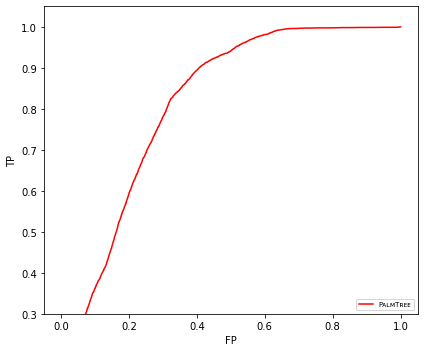

In [12]:
# calculate & draw ROC curve
from sklearn.metrics import auc
pt_total_tp = []
pt_total_fp = []

for rank in range(1, len(pt_test_embeddings_2)):
    acc_pt = 0
    fp_pt = 0

    for i in range(len(pt_target_rank_lst)):
        if pt_target_rank_lst[i] < rank:
            acc_pt += 1
            fp_pt += rank -1
        else:
            fp_pt += rank
    #print('for rank #%d, acc is %d, fp is %d '% (rank, acc_pt, fp_pt))
    pt_total_tp.append(acc_pt / num_positive)
    pt_total_fp.append(fp_pt / num_negative)

font1 = {'family' : 'DejaVu Sans',
'weight' : 'normal',
'size'   : 7,
}

# cfg_total_tp = gaussian_filter1d(cfg_total_tp, sigma=2) # make it smooth
roc_auc1 = auc(pt_total_fp, pt_total_tp)
plt.figure(figsize=(6, 5))

plt.plot(pt_total_fp, pt_total_tp, 'r-', label='PᴀʟᴍTʀᴇᴇ')
plt.legend(loc='lower right', prop=font1)
plt.xlim([-0.05, 1.05])
plt.ylim([0.3, 1.05])
plt.ylabel('TP')
plt.xlabel('FP')

plt.tight_layout()
plt.savefig(fname="bb_sim.pdf",format="pdf")
print('AUC(Area Under Curve) = %0.2f' % (roc_auc1))

## Metric Learning on Basic Blocks

### **Trying** **metric** **learning** **on** **basic** **blocks** **directly**

In [2]:
# Generate negative samples, may be inefficient
# Need to create a list of torch tensors containing 
# every other basic block embedding except the ones 
# at the current index

negative_samples = []
for i, emb in enumerate(pt_embeddings_1):
  neg_cur = []
  for j, vec in enumerate(pt_embeddings_2):
    if i != j:
      neg_cur.append(pt_embeddings_1[j])
      neg_cur.append(pt_embeddings_2[j])
  negative_samples.append(neg_cur)

negative_samples = torch.Tensor(negative_samples)
print(negative_samples.shape)

NameError: ignored

In [ ]:
def gen_neg_batch(batch_size, neg):
  negatives = torch.zeros([batch_size, 128])
  for i in range(batch_size):
    negatives[i] = neg[i][np.random.randint(0, 2697)]
  return negatives

In [ ]:
class Embedding(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(Embedding, self).__init__()

    self.l1 = nn.Linear(input_dim, hidden_dim)
    self.l2 = nn.Linear(hidden_dim, hidden_dim)
    self.l3 = nn.Linear(hidden_dim, output_dim)
    self.relu = nn.ReLU()

  def forward(self, embedding):

    out = self.l1(embedding)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)

    return out

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_metric_learning import losses, reducers
from pytorch_metric_learning.distances import SNRDistance, CosineSimilarity
import statistics

# Maybe try FastAP instead, good for ranking problems
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Embedding(128, 256, 128).to(device)
learning_rate = .001
# pytorch metric learning
reducer = reducers.MeanReducer()
criterion = losses.TripletMarginLoss(1, reducer, triplets_per_anchor='all')
# torch triplet loss
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
# optimization
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
epochs = 1000

anchor_data = torch.Tensor(pt_embeddings_1)
print(anchor_data.shape)
pos_data = torch.Tensor(pt_embeddings_2)

batch_size = 150

ref_neg_labels = torch.ones([batch_size])
ref_pos_labels = torch.zeros([batch_size])
anchor_label = torch.zeros([batch_size])
ref_labels = torch.cat((ref_pos_labels, ref_neg_labels), dim=0)

for epoch in range(epochs):
  running_loss = 0
  if epoch > 2000:
    batch_size = 450
  if epoch > 3500:
    batch_size = 675
  for i in range(0, anchor_data.shape[0], batch_size):
    # get a batch of anchors
    vec = anchor_data[i:i+batch_size].to(device)
    # get a batch of positives (must match anchor index)
    pos = pos_data[i:i+batch_size].to(device)
    # generate a batch of negatives, a single random sample for each pair
    neg = gen_neg_batch(batch_size, negative_samples[i:i+batch_size]).to(device)
    #ref_vectors = torch.cat((pos, neg), dim=0)

    # pass each through the model
    anchor_embedding = model(vec)
    pos_embedding = model(pos)
    neg_embedding = model(neg)
    #ref_embeddings = model(ref_vectors)

    optimizer.zero_grad()

    #loss = criterion(anchor_embedding, anchor_label, ref_emb=ref_embeddings, ref_labels=ref_labels)
    loss = triplet_loss(anchor_embedding, pos_embedding, neg_embedding)
    running_loss += loss.item()

    loss.backward()
    optimizer.step()

  print("epoch {} Loss: {}".format(epoch, running_loss))

Streaming output truncated to the last 5000 lines.
epoch 20000 Loss: 0.0
epoch 20001 Loss: 0.0
epoch 20002 Loss: 0.0064338273368775845
epoch 20003 Loss: 8.194676047423854e-05
epoch 20004 Loss: 6.196128106239485e-05
epoch 20005 Loss: 0.002745052333921194
epoch 20006 Loss: 0.0
epoch 20007 Loss: 0.006009578952216543
epoch 20008 Loss: 0.0
epoch 20009 Loss: 0.0035629632911877707
epoch 20010 Loss: 0.0006274470360949636
epoch 20011 Loss: 0.0004351962124928832
epoch 20012 Loss: 0.0026558914687484503
epoch 20013 Loss: 0.0
epoch 20014 Loss: 0.004548287484794855
epoch 20015 Loss: 0.0011423948453739285
epoch 20016 Loss: 0.0
epoch 20017 Loss: 0.0013037328608334064
epoch 20018 Loss: 0.0075165932066738605
epoch 20019 Loss: 0.0008837049826979637
epoch 20020 Loss: 0.004473851528018713
epoch 20021 Loss: 0.0
epoch 20022 Loss: 0.0032888016430661082
epoch 20023 Loss: 0.001991242286749184
epoch 20024 Loss: 0.002613696036860347
epoch 20025 Loss: 0.0
epoch 20026 Loss: 0.004680918995290995
epoch 20027 Loss: 0.

In [ ]:
pt_embeddings_1_metric = []
pt_embeddings_2_metric = []

test_pt_1 = pt_test_embeddings_1
test_pt_2 = pt_test_embeddings_2

for item in test_pt_1:
  #metric_embedding = torch.rand([128])
  metric_embedding = model(torch.Tensor(item).to(device))
  pt_embeddings_1_metric.append(metric_embedding)

for item in test_pt_2:
  #metric_embedding = torch.rand([128])
  metric_embedding = model(torch.Tensor(item).to(device))
  pt_embeddings_2_metric.append(metric_embedding)

In [ ]:
num_positive = len(test_embeddings)
num_negative = len(test_embeddings) * len(pt_embeddings_2_metric) - num_positive

print('# of postives:', num_positive)
print('# of negatives:', num_negative)
print("start")

pt_target_rank_lst = []

# Currently not splitting the ground_truth_bb_pairs to separate the training and test set
for key in test_embeddings.keys():
    idx = bin1_test_mapping[key]
    idy = bin2_test_mapping[key]

    pt_source = pt_embeddings_1_metric[idx].detach().cpu().numpy()

    pt_target = pt_embeddings_2_metric[idy].detach().cpu().numpy()

    pt_target_distance = np.linalg.norm(pt_source-pt_target)

    pt_distance_lst = []

    for i in range(len(pt_embeddings_2_metric)):
        pt_distance_lst.append(np.linalg.norm(pt_source-pt_embeddings_2_metric[i].detach().cpu().numpy()))

    #print('For',idx,':',pt_distance_lst)
    pt_target_rank_lst.append(sorted(pt_distance_lst).index(pt_target_distance))

# of postives: 312
# of negatives: 97032
start


In [ ]:
print(pt_target_rank_lst)

[293, 229, 6, 6, 14, 3, 30, 28, 144, 58, 4, 1, 82, 0, 6, 0, 118, 303, 0, 0, 11, 11, 7, 2, 1, 1, 0, 5, 18, 1, 1, 0, 67, 16, 29, 5, 14, 3, 0, 2, 125, 11, 68, 1, 0, 1, 0, 0, 2, 2, 4, 2, 16, 0, 0, 75, 3, 0, 103, 0, 0, 31, 71, 7, 16, 7, 85, 0, 33, 5, 67, 69, 68, 224, 13, 15, 0, 47, 29, 38, 7, 33, 6, 0, 0, 4, 1, 3, 1, 0, 2, 2, 1, 0, 54, 0, 0, 0, 7, 0, 24, 5, 0, 0, 0, 0, 0, 1, 0, 218, 6, 0, 0, 1, 0, 83, 104, 1, 85, 105, 26, 13, 153, 26, 112, 41, 3, 124, 107, 8, 7, 0, 34, 3, 9, 17, 2, 39, 44, 88, 81, 0, 2, 33, 110, 3, 15, 4, 5, 3, 8, 5, 3, 0, 185, 109, 0, 0, 0, 0, 13, 65, 3, 1, 165, 6, 1, 4, 132, 1, 2, 0, 0, 30, 3, 59, 11, 0, 0, 7, 0, 4, 20, 20, 8, 60, 26, 0, 250, 8, 1, 0, 10, 0, 2, 0, 0, 0, 0, 0, 153, 0, 48, 76, 1, 2, 0, 21, 0, 7, 21, 54, 12, 0, 3, 6, 7, 43, 118, 117, 147, 162, 5, 0, 0, 292, 7, 0, 83, 0, 298, 0, 117, 71, 3, 0, 0, 214, 0, 111, 53, 0, 0, 115, 8, 0, 0, 32, 0, 2, 19, 48, 0, 36, 1, 35, 1, 3, 0, 1, 3, 2, 0, 0, 161, 6, 244, 0, 8, 19, 1, 45, 21, 0, 69, 1, 1, 0, 0, 71, 81, 173, 0, 0, 

AUC(Area Under Curve) = 0.88


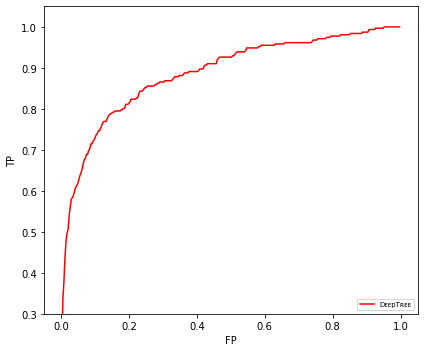

In [ ]:
from sklearn.metrics import auc
# Test metric embeddings
pt_total_tp = []
pt_total_fp = []

for rank in range(1, len(pt_embeddings_2_metric)):
    acc_pt = 0
    fp_pt = 0

    for i in range(len(pt_target_rank_lst)):
        if pt_target_rank_lst[i] < rank:
            acc_pt += 1
            fp_pt += rank -1
        else:
            fp_pt += rank

    pt_total_tp.append(acc_pt / num_positive)
    pt_total_fp.append(fp_pt / num_negative)

font1 = {'family' : 'DejaVu Sans',
'weight' : 'normal',
'size'   : 7,
}

# cfg_total_tp = gaussian_filter1d(cfg_total_tp, sigma=2) # make it smooth
roc_auc1 = auc(pt_total_fp, pt_total_tp)
plt.figure(figsize=(6, 5))

plt.plot(pt_total_fp, pt_total_tp, 'r-', label='DᴇᴇpTʀᴇᴇ')
plt.legend(loc='lower right', prop=font1)
plt.xlim([-0.05, 1.05])
plt.ylim([0.3, 1.05])
plt.ylabel('TP')
plt.xlabel('FP')

plt.tight_layout()
plt.savefig(fname="bb_sim.pdf",format="pdf")
print('AUC(Area Under Curve) = %0.2f' % (roc_auc1))

# Further Readings & References

**Papers to read**
*   Geometry of Bert: http://vigir.missouri.edu/~gdesouza/Research/Conference_CDs/IEEE_WCCI_2020/IJCNN/Papers/N-21493.pdf
* PalmTree: https://arxiv.org/pdf/2103.03809.pdf
